In [1]:
from models.lstmautoencoder import LSTMAutoencoder
from utils.loaders import SigGenDataset
from utils.trainers import BaseTrainer
import torch
from torch.utils.data import DataLoader
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.datasets import make_classification
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

Time : 5.16661889757961


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster Accuracy: 0.74


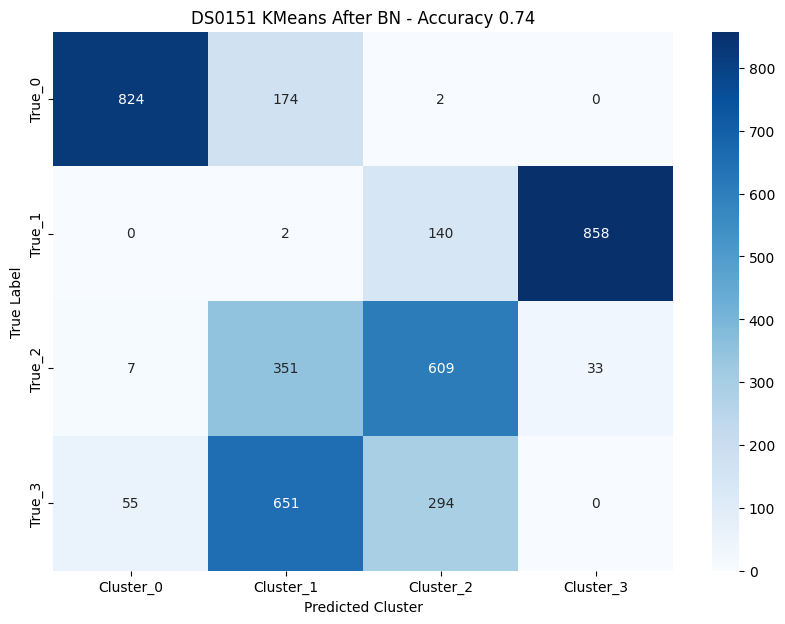

Time : 5.149877869524062


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster Accuracy: 0.72


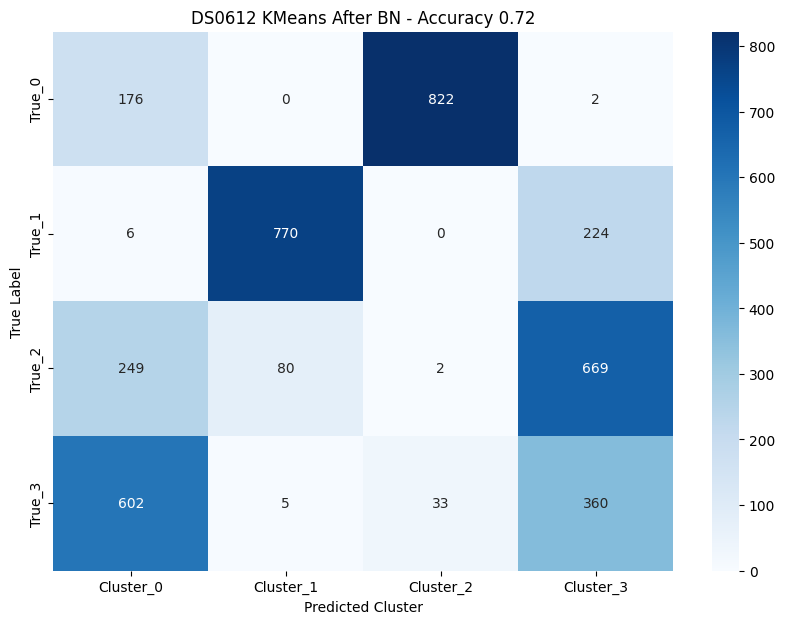

Time : 5.142679697833955


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster Accuracy: 0.79


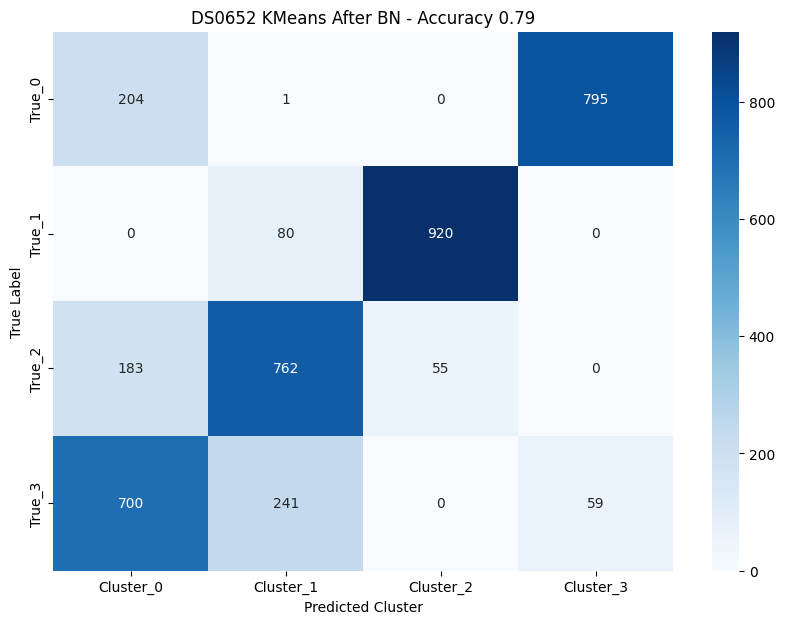

Time : 5.160836377181113


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster Accuracy: 0.77


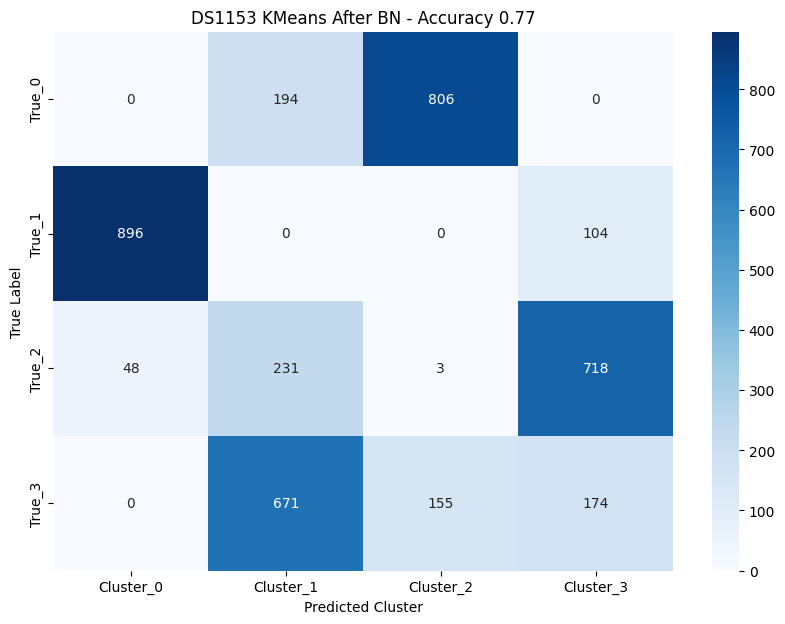

Time : 5.153237878344953


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster Accuracy: 0.34


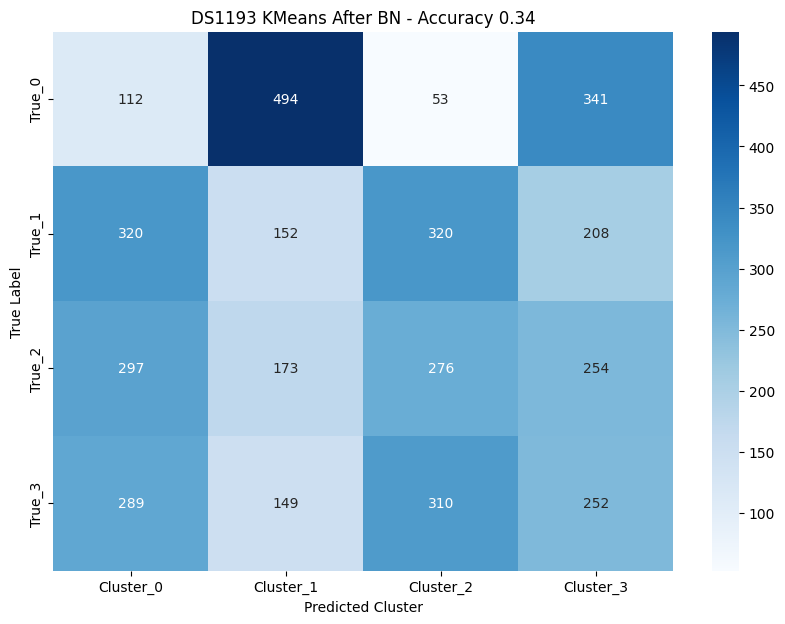

Time : 5.170942420139909


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster Accuracy: 0.62


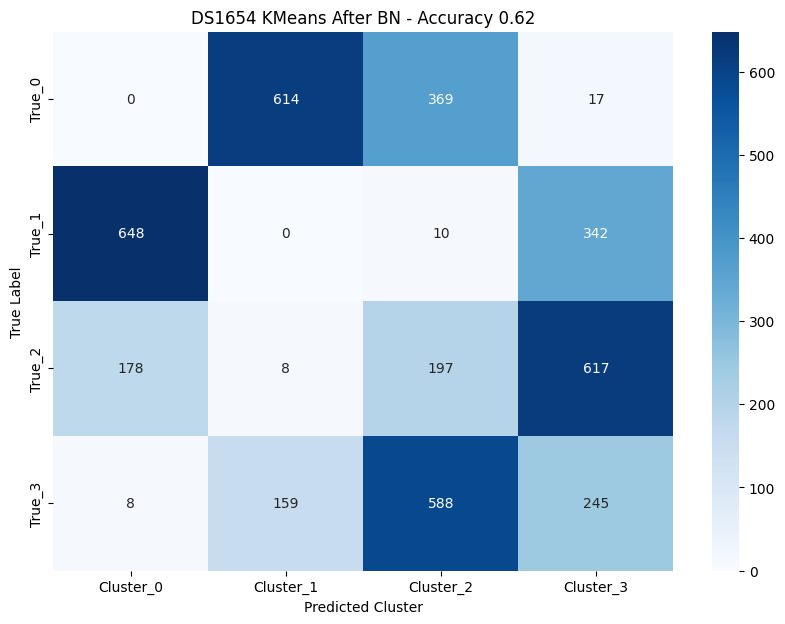

Time : 5.149932865984738


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster Accuracy: 0.38


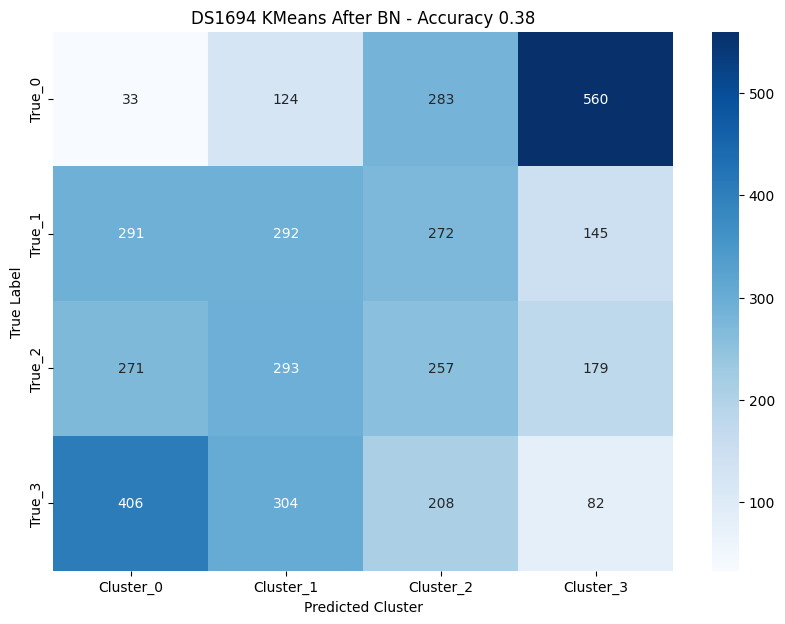

Time : 5.15375928580761


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster Accuracy: 0.63


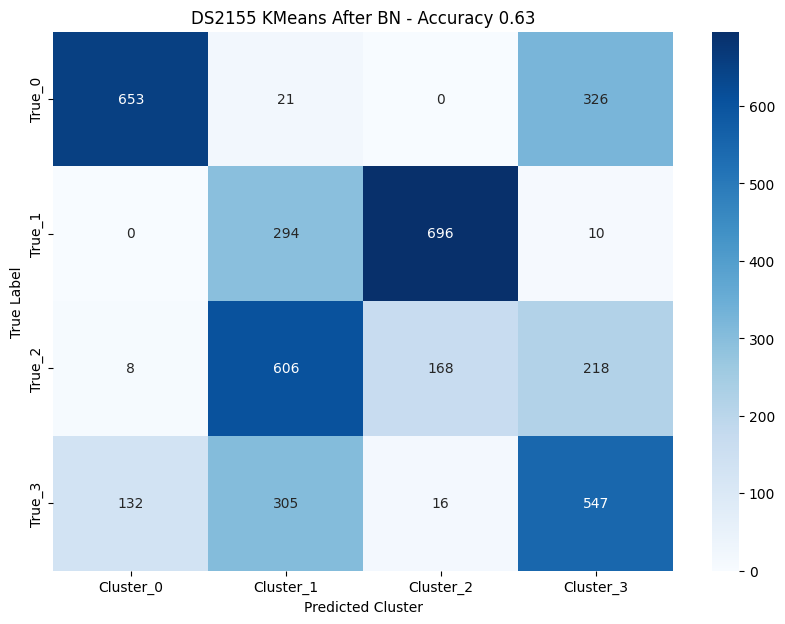

Time : 5.174993397668004


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster Accuracy: 0.57


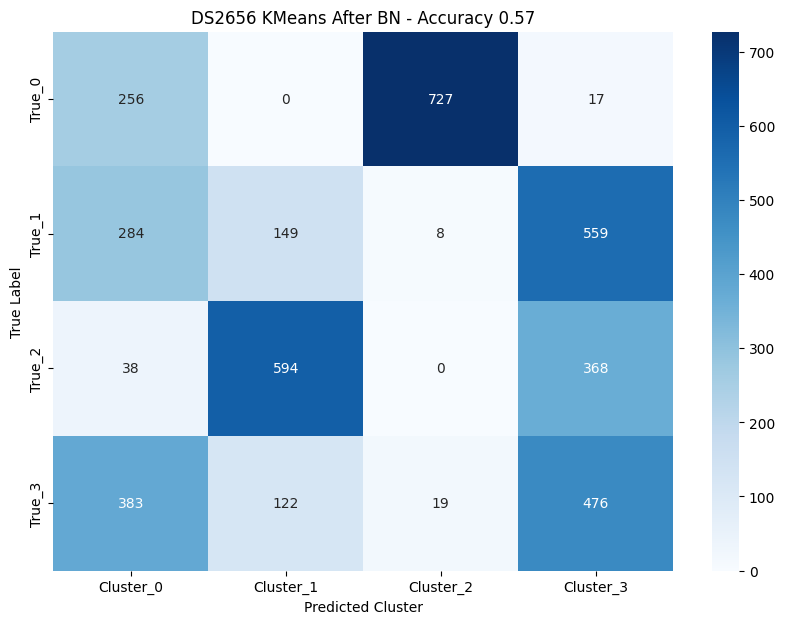

Time : 5.176912698894739


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster Accuracy: 0.31


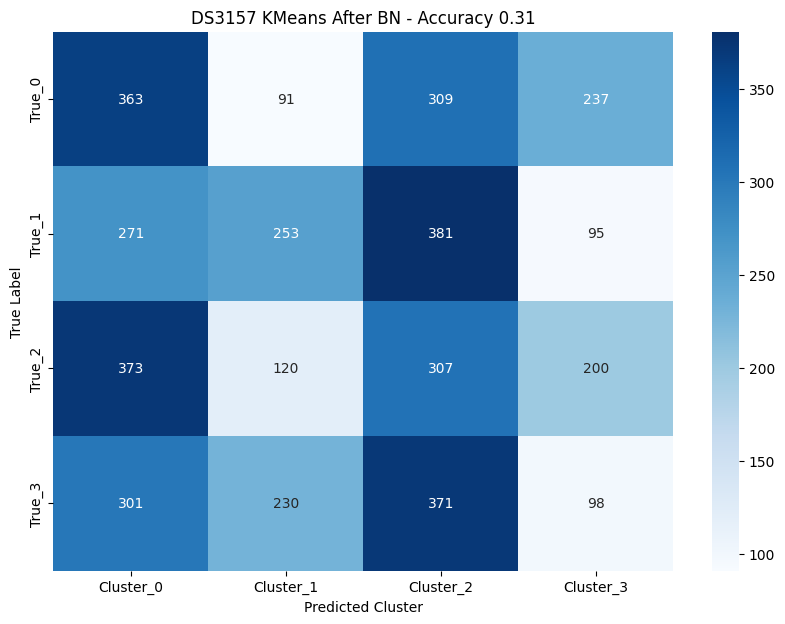

In [3]:
ds_name_array = ['DS0151',
                 'DS0612',
                 'DS0652',
                 'DS1153',
                 'DS1193',
                 'DS1654',
                 'DS1694',
                 'DS2155',
                 'DS2656',
                 'DS3157']

for ds_name in ds_name_array:
    model = LSTMAutoencoder(input_dim=1,latent_dim=128, num_layers=4, seq_length=5000).to("cuda")
    filepaths = [f'./SigGen/{ds_name}_G13000771.mat',
             f'./SigGen/{ds_name}_G13000773.mat',
             f'./SigGen/{ds_name}_G13000774.mat',
             f'./SigGen/{ds_name}_G13000775.mat']
    dataset = SigGenDataset(filepaths)
    trainers = BaseTrainer(model)
    
    # model = trainers._train(train_loader = dataset, num_epochs = 10, loss_function=torch.nn.MSELoss())
    model.load_state_dict(torch.load(f"{ds_name}_weights.pt"))
    # torch.save(model.state_dict(), f"{ds_name}_weights.pt")
    
    latent, target = trainers.extract_latent(dataset)
    
    # Initialize and fit k-Means clustering
    n_clusters = 4
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(latent)

    # Create a confusion matrix to evaluate clustering performance
    # We need to compute a mapping between cluster labels and true labels
    # First, create a confusion matrix to find out how clusters are mapped to true labels
    conf_matrix = confusion_matrix(target, clusters)

    # Find the optimal permutation of cluster labels to match true labels
    from scipy.optimize import linear_sum_assignment

    # Solve the linear sum assignment problem
    row_ind, col_ind = linear_sum_assignment(-conf_matrix)

    # Re-map clusters to the true labels
    cluster_to_label = dict(zip(col_ind, row_ind))

    # Map clusters to labels
    y_pred_mapped = np.array([cluster_to_label[cluster] for cluster in clusters])

    # Compute accuracy
    accuracy = accuracy_score(target, y_pred_mapped)
    print(f"Cluster Accuracy: {accuracy:.2f}")
    
    conf_matrix_df = pd.DataFrame(conf_matrix, 
                              index=[f'True_{i}' for i in range(conf_matrix.shape[0])],
                              columns=[f'Cluster_{i}' for i in range(conf_matrix.shape[1])])


    # Plot the confusion matrix using a heatmap
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', cbar=True)
    plt.title(f'{ds_name} KMeans After BN - Accuracy {accuracy:.2f}')
    plt.xlabel('Predicted Cluster')
    plt.ylabel('True Label')

    file_path = os.path.join('confusion_matrix', f"{ds_name}_confusion_matrix_heatmap_after_bn.png")

    plt.savefig(file_path, dpi=300)

    plt.show()